In [1]:
%load_ext autoreload
%autoreload 2
from MondrianPatches import MondrianGenerator
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision import transforms
import os
from tqdm import tqdm
from unet import load_unet_dict, save_unet_dict

In [2]:
# clear cache
torch.cuda.empty_cache()

In [3]:
def rand_mask(shape=(256, 256), shading_res=(8, 8), A=9, B=7, N=100, Rn=100, Rr=70):
    MG = MondrianGenerator(shape= shape, shading_res=shading_res)
    P = MG._perlin()
    # generate N points along a circle
    theta = torch.linspace(0, 2*torch.tensor(3.14), N)
    r = Rn * torch.ones(N)
    x0 = r*torch.cos(theta)
    y0 = r*torch.sin(theta)
    # offset so they are in the middle of the image
    x1 = x0 + torch.tensor(MG.shape[0]/2)
    y1 = y0 + torch.tensor(MG.shape[1]/2)
    rvec = (P[x1.numpy().astype(int), y1.numpy().astype(int)] + B) / A
    x2  = Rr* rvec*torch.cos(theta) + torch.tensor(MG.shape[0]/2)
    y2  = Rr* rvec*torch.sin(theta) + torch.tensor(MG.shape[1]/2)
    pts = torch.stack([x2,y2], dim=1).numpy()
    im = np.zeros(MG.shape)
    cv2.fillPoly(im, [pts.astype(int)], color=(255,255,255))
    return torch.tensor(im)

In [4]:
def rand_transformation(im):
    X = torch.zeros(im.shape, dtype=torch.float64)
    x0= torch.randint(-im.shape[0]//2, im.shape[0]//2, (1,))
    y0= torch.randint(-im.shape[1]//2, im.shape[1]//2, (1, ))
    # generate all indices
    x = torch.arange(im.shape[0])
    y = torch.arange(im.shape[1])
    # remove indices outside of image
    x_src = x[(x>=x0) & (x<x0+im.shape[0])]
    y_src = y[(y>=y0) & (y<y0+im.shape[1])]
    x_tgt = (x - x0)[(x>=x0) & (x<x0+im.shape[0])]
    y_tgt = (y - y0)[(y>=y0) & (y<y0+im.shape[1])]
    x_src, y_src = torch.meshgrid([x_src, y_src])
    x_tgt, y_tgt = torch.meshgrid([x_tgt, y_tgt])
    X[x_tgt] = im[x_src]
    return X


In [5]:
im = rand_transformation(rand_mask())

C:\tools\Anaconda3\envs\torch\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


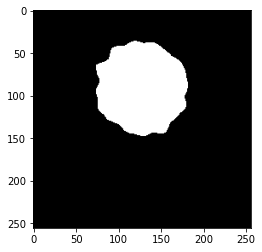

In [6]:
plt.imshow(im.numpy(), cmap='gray')

In [7]:
def deform_shading(Shading_in):
    M = rand_transformation(rand_mask()) / 255
    MG = MondrianGenerator(shape= Shading_in.shape)
    Noise = (MG._perlin() + 1)/2
    Shading_out = M * Noise + (1 - M) * Shading_in
    return Shading_out, M

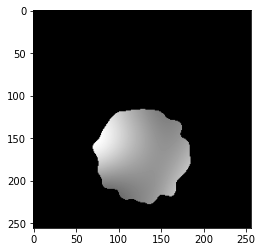

In [8]:
I = torch.zeros((256, 256))
Shading, _ = deform_shading(I)
plt.imshow(Shading, cmap='gray')

In [9]:
Shading.min()

tensor(0., dtype=torch.float64)

In [10]:
from unet import load_unet_dict

In [11]:
unet_model = load_unet_dict("unet_dict_ORIG.pt")

In [12]:
# load the image
im = torch.tensor(cv2.imread(".\\Landscapes\\00000000_(2).jpg")).permute(2,0,1)
im = transforms.Resize((256, 256))(im)

In [13]:
X = unet_model(im.unsqueeze(0).float()/255)

In [14]:
A = X[:, 0:3, :, :]
S = X[:, 3, :, :]

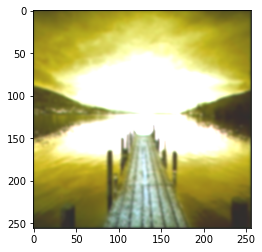

In [15]:
plt.imshow(A.detach()[0,:,:,:].permute(1, 2, 0).numpy())

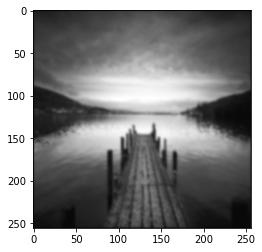

In [16]:
plt.imshow(S.detach()[0,:,:].numpy(), cmap='gray')

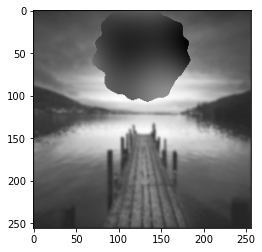

In [17]:
Sp, _ = deform_shading(S[0])
plt.imshow(Sp.detach().numpy(), cmap='gray')

In [18]:
# create image dataset
class DS(torch.utils.data.Dataset):
    def __init__(self, im_dir_path, transform=None):
        self.im_dir_path = im_dir_path
        self.transform = transform
        self.im_names = [f for f in os.listdir(im_dir_path) if f.endswith('.jpg')]
        self.im_names.sort()
    def __len__(self):
        return len(self.im_names)
    def __getitem__(self, idx):
        im_name = self.im_names[idx]
        im = cv2.imread(os.path.join(self.im_dir_path, im_name))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = torch.tensor(im).permute(2,0,1)
        im = transforms.Resize((256, 256))(im)
        if self.transform:
            im = self.transform(im)
        return im/255

In [19]:
A = DS(".\\Landscapes")

In [20]:
# create dataloader
dataloader = torch.utils.data.DataLoader(A, batch_size=4, shuffle=True)

In [21]:
imgs = next(iter(dataloader))

In [22]:
def show_batch(imgs):
    if len(imgs.shape) == 4:
        imgs = imgs.permute(0,2,3,1)
        for i in range(imgs.shape[0]):
            plt.imshow(imgs[i,:,:,:].detach().numpy())
            plt.show()
    elif len(imgs.shape) == 3:
        for i in range(imgs.shape[0]):
            plt.imshow(imgs[i,:,:].detach().numpy(), cmap='gray')
            plt.show()

In [23]:
def deform_batch(Ss):
    masks = torch.zeros(Ss.shape)
    new_S = torch.zeros(Ss.shape)
    for i in range(Ss.shape[0]):
        S = Ss[i,:,:]
        S, M = deform_shading(S)
        masks[i,:,:] = M
        new_S[i,:,:] = S
    return new_S, masks

In [24]:
def get_shading(imgs):
    X = unet_model(imgs)
    A = X[:, 0:3, :, :]
    S = X[:, 3, :, :]
    return S

In [25]:
Ss = get_shading(imgs)
NS, M = deform_batch(Ss)

In [26]:
from unet import UNet

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
disc = UNet(1, 1).to(device)

In [29]:
def train(net, epochs, batch_per_epoch):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    with tqdm(total=epochs * batch_per_epoch) as pbar:
        for epoch in range(epochs):
            for i in range(batch_per_epoch):
                imgs = next(iter(dataloader))
                Ss = get_shading(imgs)
                Ss, M = deform_batch(Ss)
                Ss = Ss.to(device)
                M = M.to(device)
                Ss = Ss.unsqueeze(1)
                M = M.unsqueeze(1)
                imgs0 = next(iter(dataloader))
                Ss0 = get_shading(imgs0).unsqueeze(1).to(device)
                M0 = torch.zeros(Ss0.shape).to(device)
                optimizer.zero_grad()
                S = net(Ss)
                S0= net(Ss0)
                loss = criterion(S, M) + criterion(S0, M0)
                loss.backward()
                optimizer.step()
                pbar.set_description("Epoch: {}, Loss: {}, Batch {}/{}".format(epoch, loss.item(), i, batch_per_epoch))
                pbar.update()

In [30]:
train(disc, 4, 20)

Epoch: 3, Loss: 0.16820234060287476, Batch 19/20: 100%|██████████| 80/80 [01:30<00:00,  1.13s/it]


In [31]:
train(disc, 8, 20)

Epoch: 7, Loss: 0.03809626027941704, Batch 19/20: 100%|██████████| 160/160 [02:45<00:00,  1.03s/it]


In [32]:
imgs = next(iter(dataloader))
Sst = get_shading(imgs)
Ss, M = deform_batch(Sst)
Ss = Ss.to(device)
M = M.to(device)
Ss = Ss.unsqueeze(1)
M = M.unsqueeze(1)

In [33]:
G = disc(Sst.unsqueeze(1).to(device))

In [34]:
torch.nn.BCELoss()(G, M)

tensor(1.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

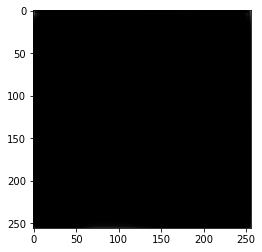

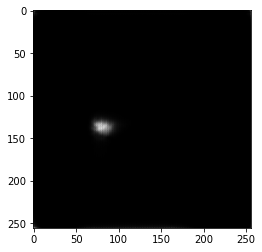

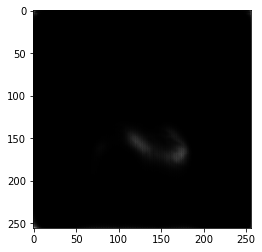

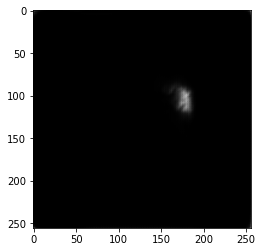

In [35]:
show_batch(G[:, 0, :, :].cpu())

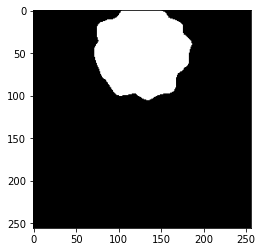

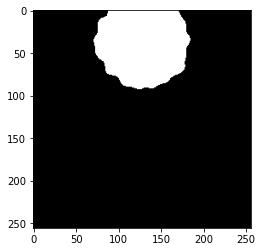

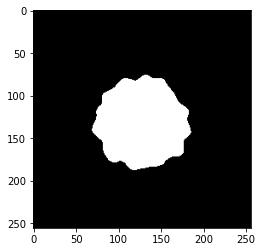

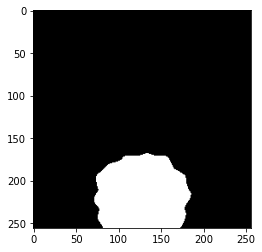

In [36]:
show_batch(M[:, 0, :, :].cpu())

In [37]:
save_unet_dict(disc, "disc_dict.pt")